
# Part I.A1.  
> ## Can we predict the sentiment of a comment using previous comments?

## A2. 
> ## The goal of this analysis is to create a model that will identify the sentiment of a review without overfitting.

## A3. 
> ## A Recurrent Neural Network (RNN) called Long Short-Term Memory or LSTM using the adam optimizer algorithm.

In [398]:
# setting the random seed for reproducibility
import random
random.seed(493)

# manipulating dataframes
import pandas as pd
import numpy as np

# nlp
import re
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import losses
from keras import optimizers
from keras import metrics

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimshellenberger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kimshellenberger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [400]:
# read to csv 
colnames=['text', 'label'] 
df_amazon = pd.read_csv('amazon_cells_labelled.txt', sep='\t', names=colnames, header=None)
df_imdb = pd.read_csv('imdb_labelled.txt', sep='\t', names=colnames, header=None)
df_yelp = pd.read_csv('yelp_labelled.txt', sep='\t', names=colnames, header=None)
df = pd.concat([df_amazon, df_imdb, df_yelp])
df = df.reset_index(drop=True)

In [402]:
df.shape

(2748, 2)

In [404]:
df.head()
df.tail()

,text,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


,text,label
2743,I think food should have flavor and texture and both were lacking.,0
2744,Appetite instantly gone.,0
2745,Overall I was not impressed and would not go back.,0
2746,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


# Part II - B1.  - the following cleaning is done to make the data functional for the model

•   presence of unusual characters (e.g., emojis, non-English characters) - Regex was utilized to find non english characters

•   vocabulary size - 4967 after removing stop words

•   proposed word embedding length - 8 based on the RMS of the square root of 4967

•   statistical justification for the chosen maximum sequence length - Utilized the mean of the length 

In [407]:
def isEnglish(c):
    try:
        c.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [409]:
non_english = []
for index, row in df.iterrows():
    for l in list(row['text']):
        for c in l:
            if isEnglish(c) == True:
                pass
            else:
                non_english.append(c)
non_english[:10]

['\x96', 'é', '\x85', '\x96', 'é', 'é', 'å', '\x96', '\x97', '\x96']

In [411]:
ADDITIONAL_STOPWORDS = []

def clean_sentence(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', sentence).split()
    word_list = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return word_list

In [413]:
def get_words(df, column):
    return clean_sentence(''.join(str(df[column].tolist())))

In [415]:
df_csat =  df.loc[df['label'] == 1]
df_dsat =  df.loc[df['label'] == 0]

In [417]:
all_words = get_words(df, 'text')
csat_words = get_words(df_csat, 'text')
dsat_words = get_words(df_dsat, 'text')

In [419]:
csat_freq = pd.Series(csat_words).value_counts()
dsat_freq = pd.Series(dsat_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [421]:
vocab_size = len(all_freq)
print('Vocabulary size: ' + str(vocab_size))

Vocabulary size: 4967


In [423]:
def show_missing(df):
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
text,0,0.0,0,0.0,0,0.0
label,0,0.0,0,0.0,0,0.0


In [425]:
word_counts = (pd.concat([all_freq, csat_freq, dsat_freq], axis=1, sort=True)
                .set_axis(['all', 'csat', 'dsat'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='all', ascending=False).head(10)

,all,csat,dsat
good,226,170,56
movie,208,101,107
great,205,188,17
film,182,96,86
phone,173,91,82
one,145,69,76
time,133,57,76
like,127,61,66
food,125,60,65
place,123,62,61


In [427]:
pd.concat([word_counts[word_counts.dsat == 0].sort_values(by='csat').tail(10),
           word_counts[word_counts.csat == 0].sort_values(by='dsat').tail(10)])

,all,csat,dsat
priced,7,7,0
town,7,7,0
joy,7,7,0
superb,7,7,0
brilliant,7,7,0
role,9,9,0
pleased,10,10,0
interesting,15,15,0
fantastic,18,18,0
delicious,23,23,0


In [429]:
def get_unigrams(words):
    return  pd.Series(words).value_counts()

def get_bigrams(words):
    return (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

def get_trigrams(words):
    return (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

def get_qualgrams(words):
    return (pd.Series(nltk.ngrams(words, 4)).value_counts())[:20]

def get_ngrams(df,column):
    return get_bigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'bigram','0':'count'}), \
           get_trigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'trigram','0':'count'}), \
           get_qualgrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'qualgram','0':'count'})

In [431]:
def viz_bigrams(df, column, title):
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

def viz_trigrams(df, column, title):
    get_trigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Trigram')
    plt.xlabel('# Occurances')
    
def viz_qualgrams(df, column, title):
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Qualgram')
    plt.xlabel('# Occurances')

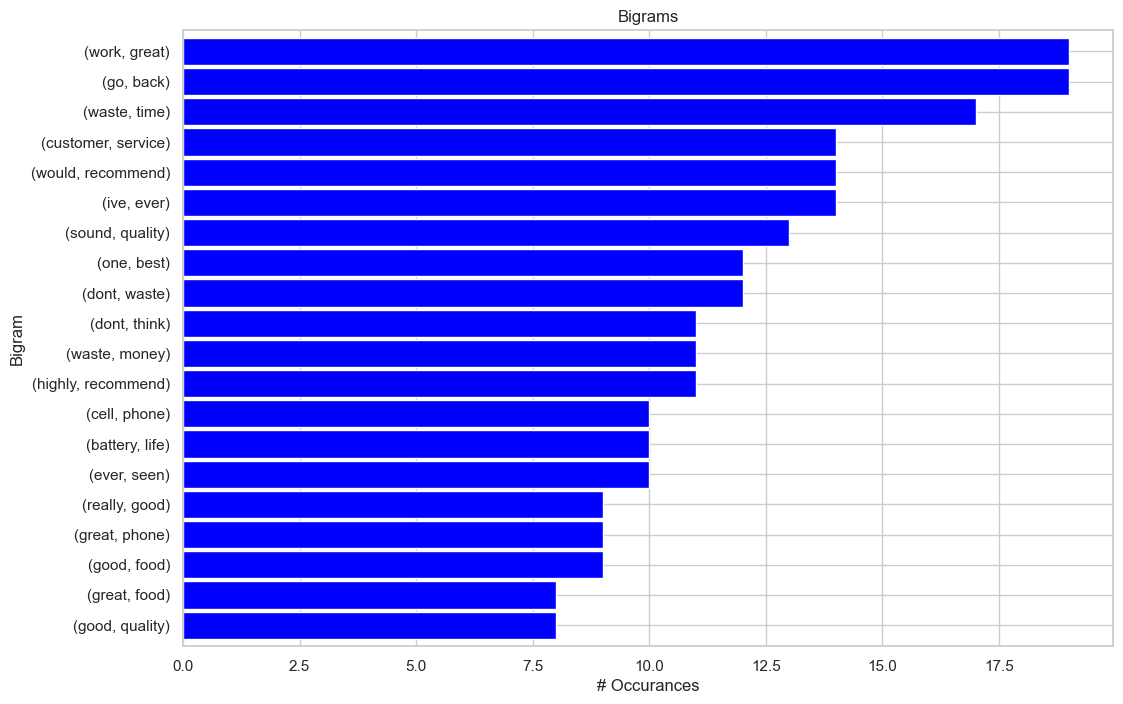

In [433]:
viz_bigrams(df, 'text', 'Bigrams')

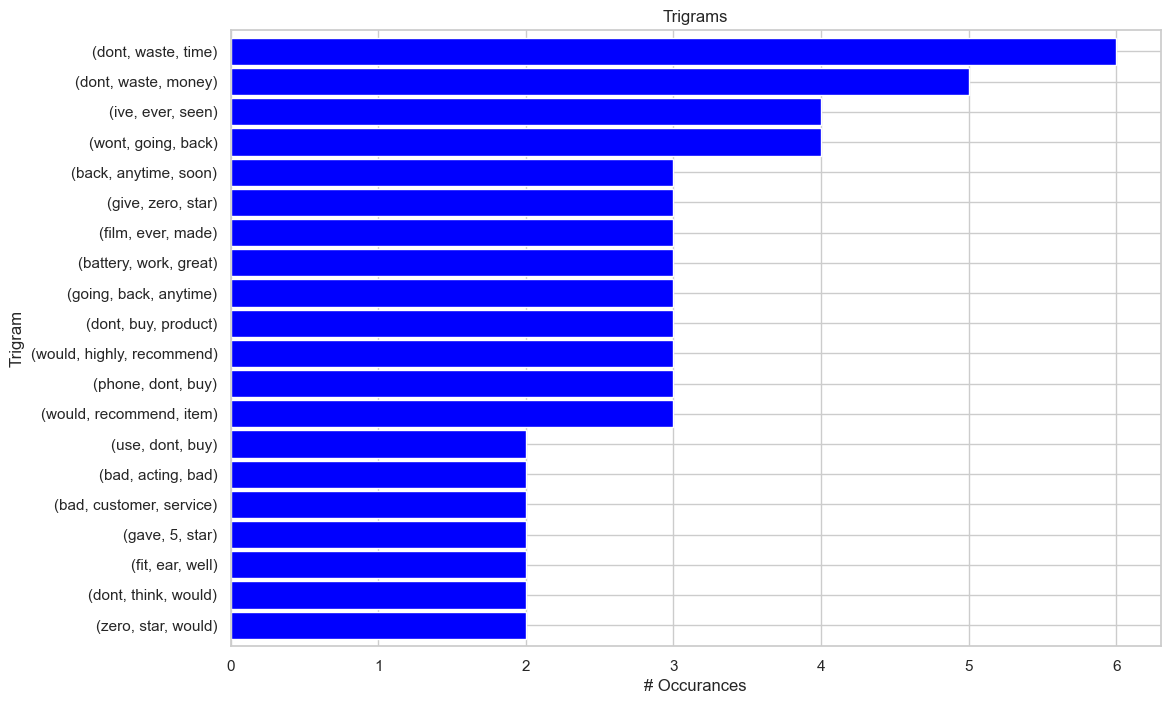

In [434]:
viz_trigrams(df, 'text', 'Trigrams')

In [437]:
df.head()
df.tail()

,text,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


,text,label
2743,I think food should have flavor and texture and both were lacking.,0
2744,Appetite instantly gone.,0
2745,Overall I was not impressed and would not go back.,0
2746,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


In [439]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print('Max sequence embedding: ' + str(max_sequence_embedding))

Max sequence embedding: 8


In [441]:
list_of_lens = []
for index, row in df.iterrows():
    list_of_lens.append(len(clean_sentence(row['text'])))
sequence_length = max(list_of_lens)
print('Sequence length: ' + str(sequence_length))

Sequence length: 789


In [443]:
mean_sequence_length = int(round(np.mean(list_of_lens), 0))
print('Mean sequence length: ' + str(mean_sequence_length))

Mean sequence length: 7


In [445]:
df['cleaned_text'] = df["text"].apply(clean_sentence)

In [447]:
df.head()

,text,label,cleaned_text
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,"[way, plug, u, unless, go, converter]"
1,"Good case, Excellent value.",1,"[good, case, excellent, value]"
2,Great for the jawbone.,1,"[great, jawbone]"
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,"[tied, charger, conversation, lasting, 45, minutesmajor, problem]"
4,The mic is great.,1,"[mic, great]"


In [449]:
def listToString(s): 
    
    # initialize an empty string 
    string = " "
    
    # return string 
    return (string.join(s)) 

In [451]:
df['clean_data'] = df['cleaned_text'].apply(listToString)

In [453]:
df.to_csv('clean_data',index = False)

In [455]:
df.head()

,text,label,cleaned_text,clean_data
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,"[way, plug, u, unless, go, converter]",way plug u unless go converter
1,"Good case, Excellent value.",1,"[good, case, excellent, value]",good case excellent value
2,Great for the jawbone.,1,"[great, jawbone]",great jawbone
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,"[tied, charger, conversation, lasting, 45, minutesmajor, problem]",tied charger conversation lasting 45 minutesmajor problem
4,The mic is great.,1,"[mic, great]",mic great


In [457]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [459]:
split = round(len(df)*0.8)
train_reviews = df['clean_data'][:split]
train_label = df['label'][:split]
test_reviews = df['clean_data'][split:]
test_label = df['label'][split:]

In [461]:
df.to_csv('train_reviews', index = False)
df.to_csv('train_label', index = False)
df.to_csv('test_reviews', index = False)
df.to_csv('test_label', index = False)

In [463]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

In [465]:
vocab_size = 4967
embedding_dim = 8
max_length = 10
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [467]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

## B3. Padding adds zeros to shorter reviews so all the reviews are the same length (nessesary to run the model)
## B4. 2 categories will be used based on the 0/1, negative/positive sentiment outcomes and the output layer in the model will be sigmoid for the binary capabilities.

In [469]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [471]:
testing_padded [:1]

array([[  0,   0,   0,  16,  55,  15, 109,  47,   1, 717]], dtype=int32)

In [474]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [476]:
activation = 'softmax'
loss = 'binary_crossentropy'
optimizer = 'adam'
num_epochs = 20

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=5)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])
model.summary()
history = model.fit(padded, training_labels_final, epochs=num_epochs, callbacks=[early_stopping_monitor], validation_data=(testing_padded, testing_labels_final))

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5293 - loss: 0.6924 - val_accuracy: 0.4527 - val_loss: 0.6930
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.5396 - loss: 0.6816 - val_accuracy: 0.6182 - val_loss: 0.6686
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7892 - loss: 0.6131 - val_accuracy: 0.7000 - val_loss: 0.5902
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.8919 - loss: 0.4381 - val_accuracy: 0.7418 - val_loss: 0.5236
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.9390 - loss: 0.2608 - val_accuracy: 0.7855 - val_loss: 0.4814
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.9483 - loss: 0.1648 - val_accuracy: 0.7800 - val_loss: 0.5023
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.9613 - loss: 0.1126 - val_accuracy: 0.7818 - val_loss: 0.5362
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.9685 - loss: 0.0921 - val_accuracy: 0.75

In [478]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 10, 8)          │        39,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,509 (470.74 KB)

 Trainable params: 40,169 (156.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,340 (313.83 KB)

In [480]:
model.save('Model.keras')

Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

<Figure size 640x480 with 0 Axes>

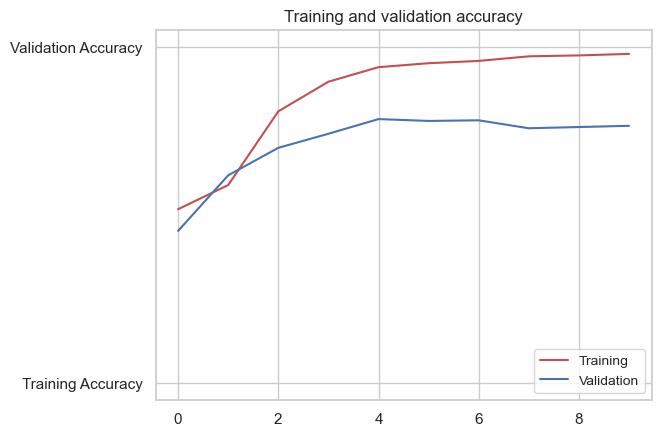

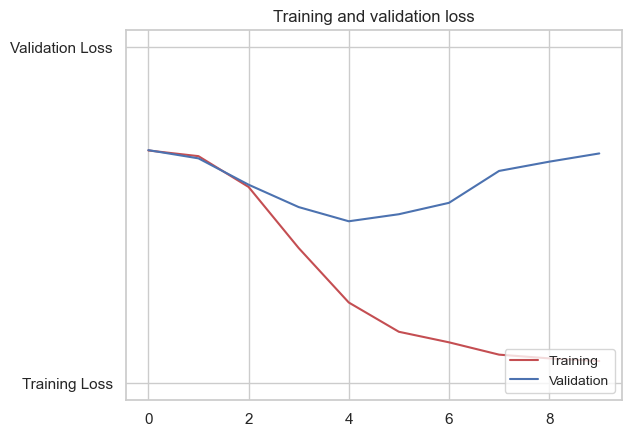

<Figure size 640x480 with 0 Axes>

In [482]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy', label="Training")
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy', label="Validation")
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.figure()

In [484]:
print(model.layers)
model.save('/Users/kimshellenberger/Downloads/model.keras')

[<Embedding name=embedding_11, built=True>, <GlobalAveragePooling1D name=global_average_pooling1d_11, built=True>, <Dense name=dense_32, built=True>, <Dense name=dense_33, built=True>, <Dense name=dense_34, built=True>]


## 2.  Discuss the number of layers, the type of layers, and the total number of parameters.
There is a total of 5 layers including 3 dense layers and the total parameters equal 120,509.

## 3.  
•   activation functions - Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities. The probabilities of each value are proportional to the relative scale of each value in the vector. 
Relu function was used in the hidden layers and the sigmoid function was used for the output due to being binary.

•   number of nodes per layer - I went with 16,16,1 for the layers based on the common starting points documented

•   loss function - the outcome is binary so it made sense to used the binary crossentropy function

•   optimizer - the Adam optomizer algorithm was used 

•   stopping criteria - suggested to stay between 1-5 and I chose 5 to improve the chance of higher accuracy

•   evaluation metric - accuracy because that tells us how likely an accurate prediction will occur using this model.



## D1. I used a higher quantity of epochs (20) so the stopping/patience setting naturally stopped at a high accurancy point which ceased running at 10 epochs.

## 2.  Overfitting was mild but could be improved through further experimentation with the model.

## 3.  See charts above

## 4.  The final model showed a 98% predictive probability.


## Part V: Summary and Recommendations

E.  See notebook file


F. The model has a very high accuracy rate with a little overfitting. Due to the high accuracy it makes sense to keep reusing the model to predict additional binary review type datasets. 

The architecture of the model contained 5 layers with 3 dense layers accounting for the binary output. 
The model uses the following architecture:
Activation: Softmax as suggested by research
number of nodes per layer: 16 nodes for each of the first
two RELU layers, and 1 node in the final Sigmoid layer which produced an accuracy of over 98%
Loss function = BinaryCrossentropy. Good for binary outcomes.
Optimizer = Adam. Suggested as the easiest optiimizer to use for this use case.

G. Use the model on other data sets to determine if reviews will be positive or negative after doing some more adjustments to optomize accuracy and limit overfitting. 

H. See attached files

# Part VI
## I & J
- https://builtin.com/machine-learning/adam-optimization
- https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f
- https://www.datacamp.com/cheat-sheet/regular-expresso?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720830&utm_adgroupid=152984016894&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=703052949720&utm_targetid=dsa-2219652735816&utm_loc_interest_ms=&utm_loc_physical_ms=9032916&utm_content=DSA~blog~Data-Science&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-us_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na-june24&gad_source=1&gclid=Cj0KCQjw4MSzBhC8ARIsAPFOuyXkxgRzxjozfKHPtnSznKabjaAnHYSbGtHCIHi-OmpkMNLYGbMHPA4aAkOKEALw_wcB
- https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences
- https://wandb.ai/ayush-thakur/dl-question-bank/reports/ReLU-vs-Sigmoid-Function-in-Deep-Neural-Networks--VmlldzoyMDk0MzI
- https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
- https://blogs.rstudio.com/ai/posts/2017-12-07-text-classification-with-keras/
